# **Profit or Planet**  
### As the companies make more money, do they care more about the society and sustainability? 

### Are Energy Companies actually are about net zero?, Here this article will collect and summarised the evidence 

It is obvious that when we do business, we need profit and revenue inorder to survive. But for big companies who have enough money to survive, are they focusing on their growth, profitbailtiy or what they can do to the society? 

Questions:
- How do financial and ESG indicators correlate for major UK energy firms?
- Can we classify companies as profit-focused or sustainability-focused based on their data?
- Which companies show a balanced profile (profit + ESG performance)?
- Has this balance shifted over time (2015–2025)?
- What's better for the long term position of the company? Profitability ??? or Sustainabiltiy 


Companies that will be asses in this projects are include Shell and BP (Oil & Gas firm), Rolls-Royce Holdings plc (Nuclear Fission), SSE 

In [515]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


tickers = ["BP", "SHEL", "XOM", "CNA.L", "RR.L", "SSE.L", "DRX.L"]

data = {t: yf.Ticker(t) for t in tickers}

prices = yf.download(tickers, start="2015-10-11")['Close']   # Work with just closing prices 


## Clean and Check for missing values 
prices.isnull().sum()         ## 
prices = prices.ffill().dropna() 

prices.tail()


/var/folders/m5/pl7f3qbs4wz97g9ld9_84ysw0000gn/T/ipykernel_33757/3953884610.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start="2015-10-11")['Close']   # Work with just closing prices
[*********************100%***********************]  7 of 7 completed


Ticker,BP,CNA.L,DRX.L,RR.L,SHEL,SSE.L,XOM
Date,,,,,,,
2025-10-16,32.779999,175.149994,720.0,1140.0,71.370003,1864.5,110.639999
2025-10-17,33.130001,174.250000,710.0,1103.0,72.589996,1878.5,112.239998
2025-10-20,33.220001,171.899994,707.5,1127.0,72.820000,1871.5,112.699997
2025-10-21,33.160000,173.649994,709.0,1134.5,72.669998,1893.5,112.709999
2025-10-22,33.160000,175.949997,724.0,1137.0,72.669998,1905.0,112.709999


## **Return and Volatility** 

In [516]:
returns = prices.pct_change()
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)

market_summary = pd.DataFrame({'Annual Return': annual_returns, 'Volatility': annual_volatility})
market_summary.sort_values(by='Annual Return', ascending=False)

,Annual Return,Volatility
Ticker,,
RR.L,0.261721,0.482867
DRX.L,0.156725,0.361239
SHEL,0.122498,0.302012
XOM,0.115404,0.276629
BP,0.099898,0.311628
SSE.L,0.050510,0.242639
CNA.L,0.026084,0.330993


/var/folders/m5/pl7f3qbs4wz97g9ld9_84ysw0000gn/T/ipykernel_33757/585969483.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 1, 1, 1])


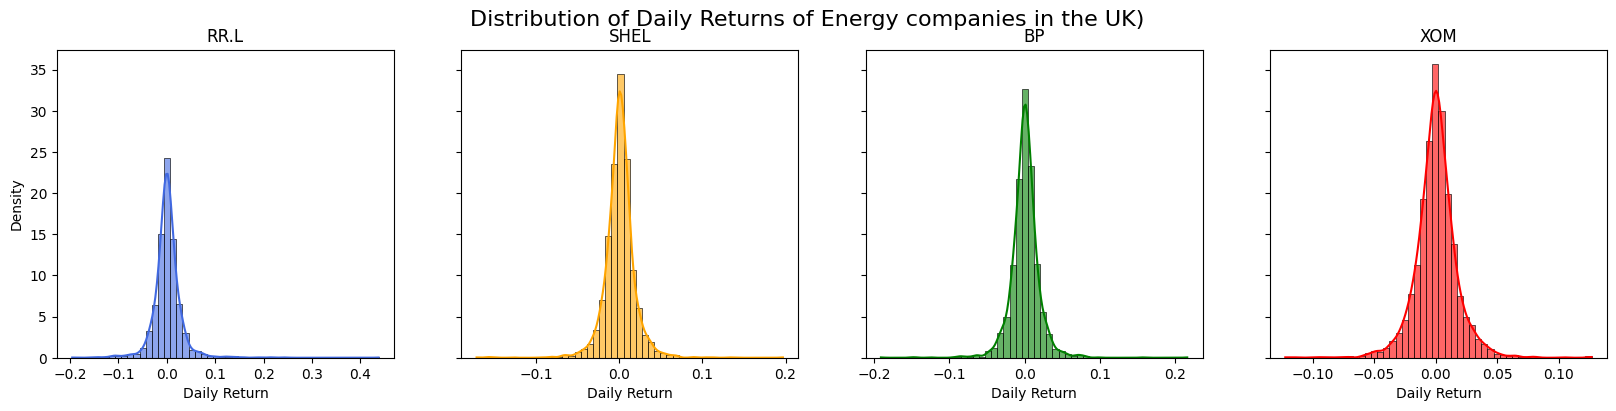

In [517]:
# ...existing code...

tickers_to_plot = ['RR.L', 'SHEL', 'BP', 'XOM']
colors = ['royalblue', 'orange', 'green', 'red']

fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

for ax, ticker, color in zip(axes, tickers_to_plot, colors):
    sns.histplot(returns[ticker].dropna(), bins=50, kde=True, color=color, ax=ax, stat='density', alpha=0.6)
    ax.set_title(ticker)
    ax.set_xlabel("Daily Return")
    if ax == axes[0]:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")

plt.suptitle("Distribution of Daily Returns of Energy companies in the UK)", fontsize=16)
plt.tight_layout(rect=[0, 1, 1, 1])
plt.show()

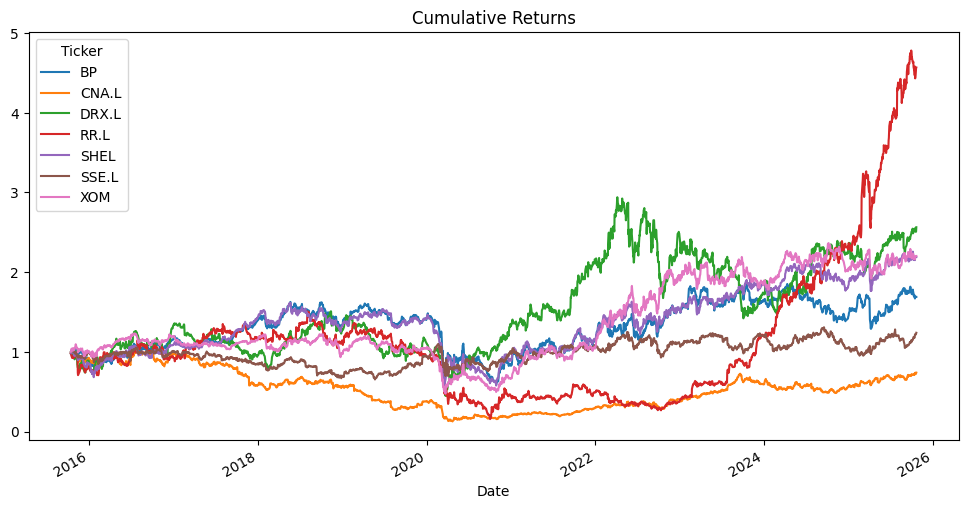

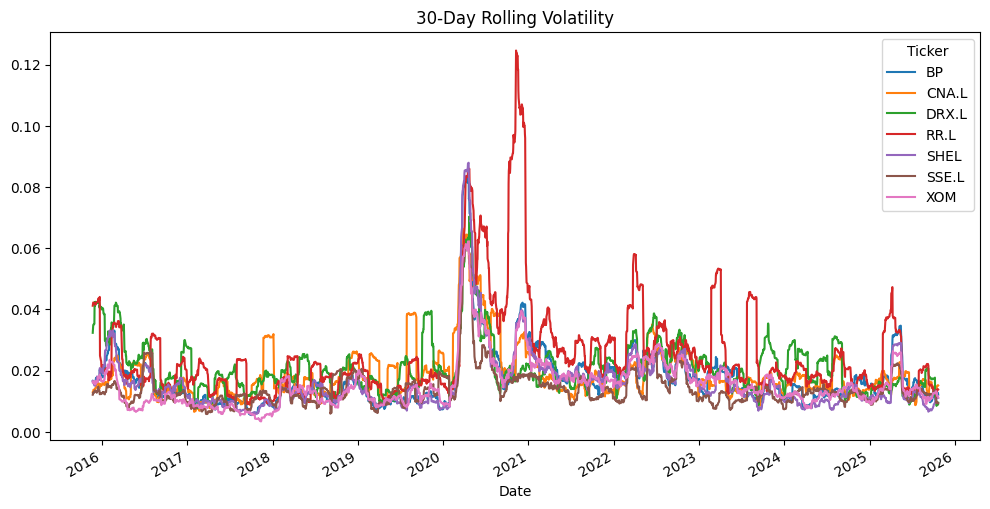

In [518]:
# Cumulative returns
Cumulative_Return = (1 + returns).cumprod()

# Cumulative returns
Cumulative_Return.plot(figsize=(12,6), title="Cumulative Returns")
plt.show()

Volatility = returns.rolling(window=30).std()

Volatility .plot(figsize=(12,6), title="30-Day Rolling Volatility")
plt.show()

## **Financial Statement analysis**

In [519]:
# Create a dictionary to store financial data
oil_compa = ["BP", "SHEL", "XOM"]
alter_ener = ["CNA.L", "RR.L", "SSE.L", "DRX.L"]

financials = {}

for t in oil_compa:
    fin = data[t].financials
    bal = data[t].balance_sheet
    cash = data[t].cashflow
    
    try:
        # Extract from financial statements
        revenue = fin.loc['Total Revenue'].iloc[0]
        opera = fin.loc['Operating Income'].iloc[0]
        net = fin.loc['Net Income'].iloc[0]
        gross = fin.loc['Gross Profit'].iloc[0]
        
        # Extract from balance sheet
        assets = bal.loc['Total Assets'].iloc[0]
        liabilities = bal.loc['Total Liabilities Net Minority Interest'].iloc[0]
        equity = bal.loc["Stockholders Equity"].iloc[0]
        
        # Extract from cash flow statement
        capex = cash.loc['Capital Expenditure'].iloc[0]
        operating_cf = cash.loc['Operating Cash Flow'].iloc[0]
        
        
        # Compute margins
        op_margin = (opera / revenue) * 100 # Operating profit margin
        net_margin = (net / revenue) * 100 # Net profit margin
        gross_margin = (gross / revenue) * 100 # Gross profit margin
        
        de_ratio = liabilities / equity   # Debt-to-Equity ratio
        roe = (net / equity) * 100  # Return on Equity
        
        fcf = operating_cf - capex  # Free Cash Flow
        
        # --- Store results ---
        financials[t] = {
            'Revenue (B$)': revenue / 1e9,
            'Operating Margin (%)': op_margin,
            'Net Margin (%)': net_margin,
            'Gross Margin (%)': gross_margin,
            'ROE (%)': roe,
            'Debt-to-Equity': de_ratio,
            'Total Assets (B$)': assets / 1e9,
            'Free Cash Flow (B$)': fcf / 1e9
        }
    except KeyError:
        print(f" Missing data for {t}")
        continue

# Create a DataFrame
fin_df = pd.DataFrame(financials).T.round(2)

fin_df



,Revenue (B$),Operating Margin (%),Net Margin (%),Gross Margin (%),ROE (%),Debt-to-Equity,Total Assets (B$),Free Cash Flow (B$)
BP,189.18,7.20,0.20,15.98,0.64,3.44,282.23,42.59
SHEL,284.31,10.55,5.66,16.16,9.03,1.16,387.61,74.29
XOM,339.25,11.69,9.93,22.62,12.77,0.69,453.48,79.33


In [520]:
alter_ener = ["CNA.L", "RR.L", "SSE.L", "DRX.L"]

financials = {}

for t in alter_ener:
    fin = data[t].financials
    bal = data[t].balance_sheet
    cash = data[t].cashflow
    
    try:
        # Extract from financial statements
        revenue = fin.loc['Total Revenue'].iloc[0]
        opera = fin.loc['Operating Income'].iloc[0]
        net = fin.loc['Net Income'].iloc[0]
        gross = fin.loc['Gross Profit'].iloc[0]
        
        # Extract from balance sheet
        assets = bal.loc['Total Assets'].iloc[0]
        liabilities = bal.loc['Total Liabilities Net Minority Interest'].iloc[0]
        equity = bal.loc["Stockholders Equity"].iloc[0]
        
        # Extract from cash flow statement
        capex = cash.loc['Capital Expenditure'].iloc[0]
        operating_cf = cash.loc['Operating Cash Flow'].iloc[0]
        
        
        # Compute margins
        op_margin = (opera / revenue) * 100 # Operating profit margin
        net_margin = (net / revenue) * 100 # Net profit margin
        gross_margin = (gross / revenue) * 100 # Gross profit margin
        
        de_ratio = liabilities / equity   # Debt-to-Equity ratio
        roe = (net / equity) * 100  # Return on Equity
        
        fcf = operating_cf - capex  # Free Cash Flow
        
        # --- Store results ---
        financials[t] = {
            'Revenue (B$)': revenue / 1e9,
            'Operating Margin (%)': op_margin,
            'Net Margin (%)': net_margin,
            'Gross Margin (%)': gross_margin,
            'ROE (%)': roe,
            'Debt-to-Equity': de_ratio,
            'Total Assets (B$)': assets / 1e9,
            'Free Cash Flow (B$)': fcf / 1e9
        }
    except KeyError:
        print(f" Missing data for {t}")
        continue

# Create a DataFrame
fin_df_alter_uk = pd.DataFrame(financials).T.round(2)

### Attempting to convert to US_Dollars 

In [521]:
# Fetch the last year of GBP→USD exchange rate data
fx_data = yf.download('GBPUSD=X')
gbp_to_usd = fx_data['Close'].dropna().mean()

# Extract scalar value if gbp_to_usd is a Series
if hasattr(gbp_to_usd, 'iloc'):
	gbp_to_usd = gbp_to_usd.iloc[0] if hasattr(gbp_to_usd, 'iloc') else float(gbp_to_usd)

# Identify companies traded in GBP
gbp_mask = fin_df_alter_uk.index.str.endswith('.L')

# Columns to convert (absolute values only)
cols_to_convert = ["Revenue (B$)", "Total Assets (B$)", "Free Cash Flow (B$)"]

# Convert to numeric (in-place, ignore errors)
fin_df_alter_uk[cols_to_convert] = fin_df_alter_uk[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert GBP values to USD for UK companies
fin_df_alter_uk.loc[gbp_mask, cols_to_convert] = fin_df_alter_uk.loc[gbp_mask, cols_to_convert] * gbp_to_usd

# Optionally, rename columns to indicate USD
# fin_df_alter_uk.rename(
# 	columns={col: col.replace('(B$)', '(BUSD)') for col in cols_to_convert},
# 	inplace=True
# )

fin_df_alter_uk


/var/folders/m5/pl7f3qbs4wz97g9ld9_84ysw0000gn/T/ipykernel_33757/2945546496.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download('GBPUSD=X')
[*********************100%***********************]  1 of 1 completed


,Revenue (B$),Operating Margin (%),Net Margin (%),Gross Margin (%),ROE (%),Debt-to-Equity,Total Assets (B$),Free Cash Flow (B$)
CNA.L,26.709836,9.78,6.69,20.52,30.12,3.15,25.126832,2.092785
RR.L,25.368307,14.46,13.33,22.32,-276.43,-40.10,47.879158,6.264939
SSE.L,13.589685,22.00,11.74,38.13,9.86,1.46,40.728810,7.525976
DRX.L,8.263817,14.83,8.55,30.45,25.35,1.59,7.230840,1.676911


- Operating Margin -> how efficient core operations are
- Net Margin -> profitability after all expenses
- ROE -> how well equity is generating profits
- Debt-to-Equity -> leverage (risk structure)
- Asset Turnover -> how effectively assets generate revenue


Cash flow statement 
- Operating activities → cash generated from day-to-day business
- Investing activities → cash spent on growth (e.g., new equipment, acquisitions) 
- Financing activities → cash from or to investors (e.g., debt, dividends, buybacks)


## **Financial Comparison** 
Comparing Revenue, Total Assets and Free Cash Flow 

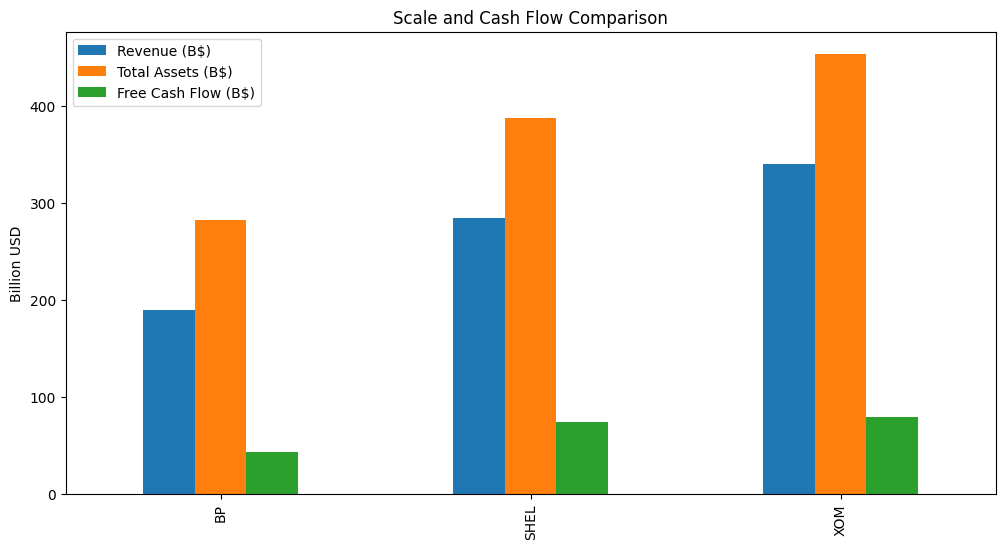

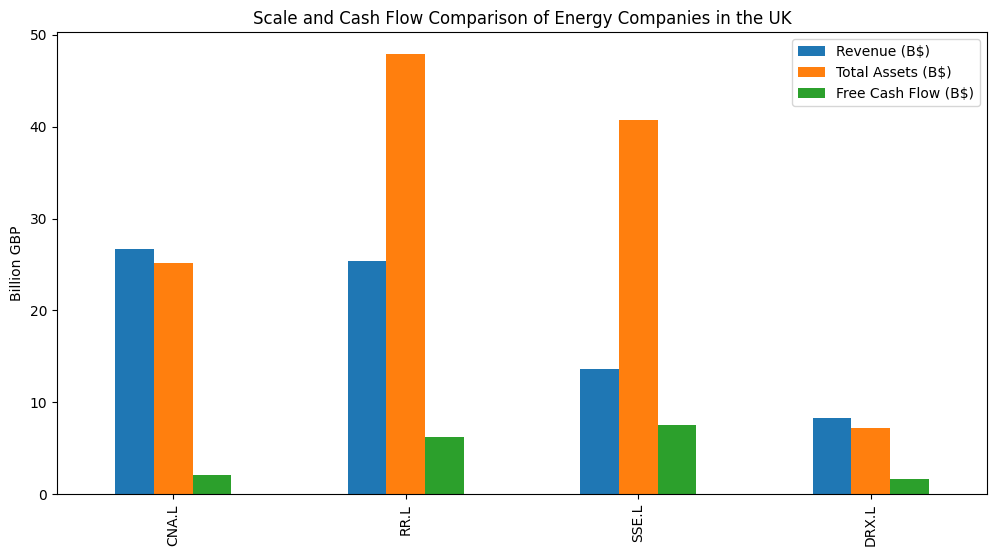

In [522]:
fin_df[['Revenue (B$)', 'Total Assets (B$)', 'Free Cash Flow (B$)']].plot(kind='bar', figsize=(12,6))
plt.title('Scale and Cash Flow Comparison')
plt.ylabel('Billion USD')
plt.show()

fin_df_alter_uk[['Revenue (B$)', 'Total Assets (B$)', 'Free Cash Flow (B$)']].plot(kind='bar', figsize=(12,6))
plt.title('Scale and Cash Flow Comparison of Energy Companies in the UK')
plt.ylabel('Billion GBP')
plt.show()




ExxonMobil exhibit the highest revenue, assets free cash flow, following by Shell and BP respectively, reflecting their company sizes. Among the UK-based energy companies, SSE has the highest cash flow while Rolls-Royce have the most assets compare to its revenue. 

## **Profitability Comparison** 
Assessing Profitability ratios, all of the companies can be compared together because the ratio metrics are currecies independent 

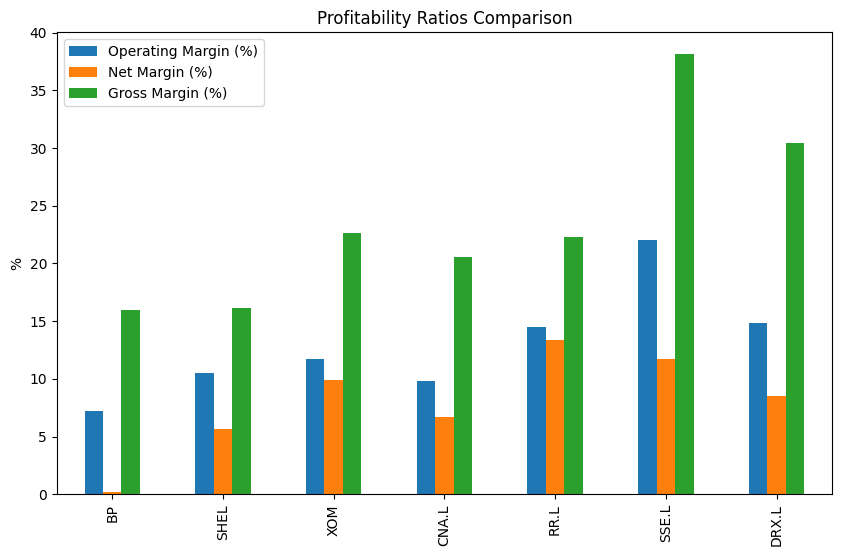

In [523]:
# Select the columns you want from each DataFrame
cols = ['Operating Margin (%)', 'Net Margin (%)', 'ROE (%)', 'Gross Margin (%)','Debt-to-Equity']

# Combine the selected columns from both DataFrames
combined_df = pd.concat([fin_df[cols], fin_df_alter_uk[cols]])


combined_df[['Operating Margin (%)', 'Net Margin (%)', 'Gross Margin (%)']].plot(kind='bar', figsize=(10,6))
plt.title('Profitability Ratios Comparison')
plt.ylabel('%')
plt.show()

## **Evaluating Risk**

RR.L’s negative ROE and Debt-to-Equity stem from negative shareholders’ equity following pandemic losses and restructuring. These ratios are not directly comparable with other firms, as they reflect accounting deficits rather than ongoing operational inefficiency.

Rolls-Royce Holdings plc (RR.L) has had negative shareholder equity, which occurred when its liabilities exceeded its assets, largely due to the costs from engine problems (specifically the Trent 1000 engine) and accounting changes. However, the company has been working to improve its financial situation through cost reductions and operational restructuring. The company's financial performance has improved, with increased operating profit and free cash flow. This has led to a positive outlook for investors, and the company plans to reintroduce dividends. A company with negative equity owes more than it owns, a situation that can be risky. However, improvements in operational efficiency and cash flow indicate a turnaround is underway, making the situation less critical than it was previously.





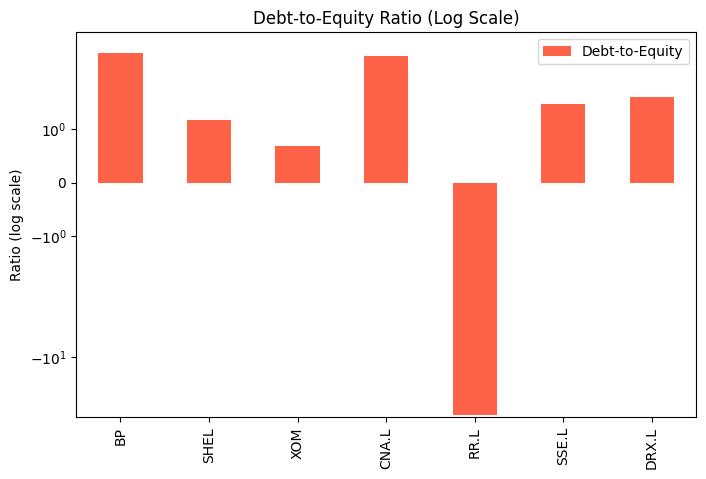

In [524]:
combined_df[['Debt-to-Equity']].plot(kind='bar', color='tomato', figsize=(8,5))
plt.yscale('symlog')  # handles both positive and negative values
plt.title('Debt-to-Equity Ratio (Log Scale)')
plt.ylabel('Ratio (log scale)')
plt.legend()
plt.show()

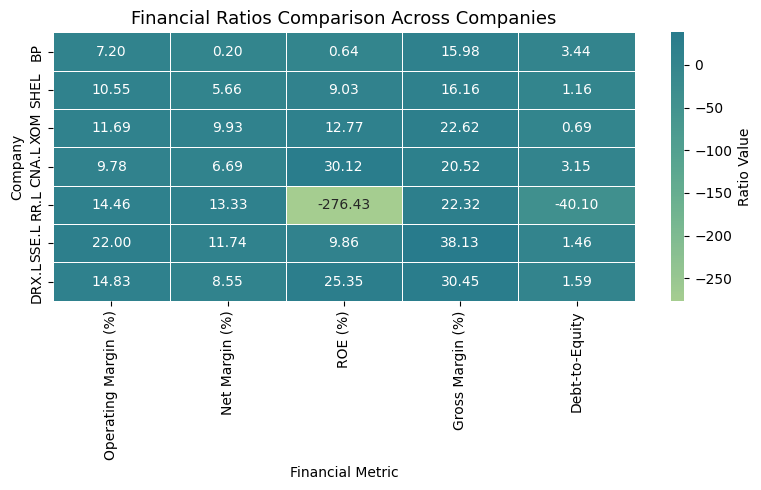

In [525]:
plt.figure(figsize=(8,5))
sns.heatmap(combined_df, annot=True, fmt=".2f", cmap='crest', center=0,
            linewidths=0.5, cbar_kws={'label': 'Ratio Value'})
plt.title('Financial Ratios Comparison Across Companies', fontsize=13)
plt.ylabel('Company')
plt.xlabel('Financial Metric')
plt.tight_layout()
plt.show()

# *How sustainable are they?*

Financial analysis and metrics on the above section demonstrate the performance of the companies, but have you ever wonder, if these companies become more responsible to the world as they perform better or generate more profit?  

This section will analyse how sustainability they are and if they put more investment in attempting reducing carbon emissions


In [526]:
import os

tickers = ["BP.L", "SHEL.L", "XOM", "RR.L", "SSE.L", "CNA.L", "DRX.L"]

esg_data = []
for t in tickers:
    ticker = yf.Ticker(t)
    esg = ticker.sustainability
    if esg is not None:
        df = esg.T
        df["company_ticker"] = t
        esg_data.append(df)

esg_df = pd.concat(esg_data).set_index("company_ticker")
esg_df = esg_df[['totalEsg','environmentScore', 'socialScore', 'governanceScore']]
# Rename index values in esg_df to match those in combined_df
esg_df = esg_df.rename(index={'BP.L': 'BP', 'SHEL.L': 'SHEL'})



combined_full = combined_df.merge(esg_df, left_index=True, right_index=True, how='left')
combined_full



,Operating Margin (%),Net Margin (%),ROE (%),Gross Margin (%),Debt-to-Equity,totalEsg,environmentScore,socialScore,governanceScore
BP,7.20,0.20,0.64,15.98,3.44,30.44,18.19,9.81,2.44
SHEL,10.55,5.66,9.03,16.16,1.16,31.11,21.25,7.83,2.03
XOM,11.69,9.93,12.77,22.62,0.69,39.97,24.79,10.27,4.91
CNA.L,9.78,6.69,30.12,20.52,3.15,24.86,10.17,12.3,2.39
RR.L,14.46,13.33,-276.43,22.32,-40.10,25.78,9.47,13.24,3.07
SSE.L,22.00,11.74,9.86,38.13,1.46,20.93,7.4,12.25,1.29
DRX.L,14.83,8.55,25.35,30.45,1.59,20.68,9.26,9.23,2.19


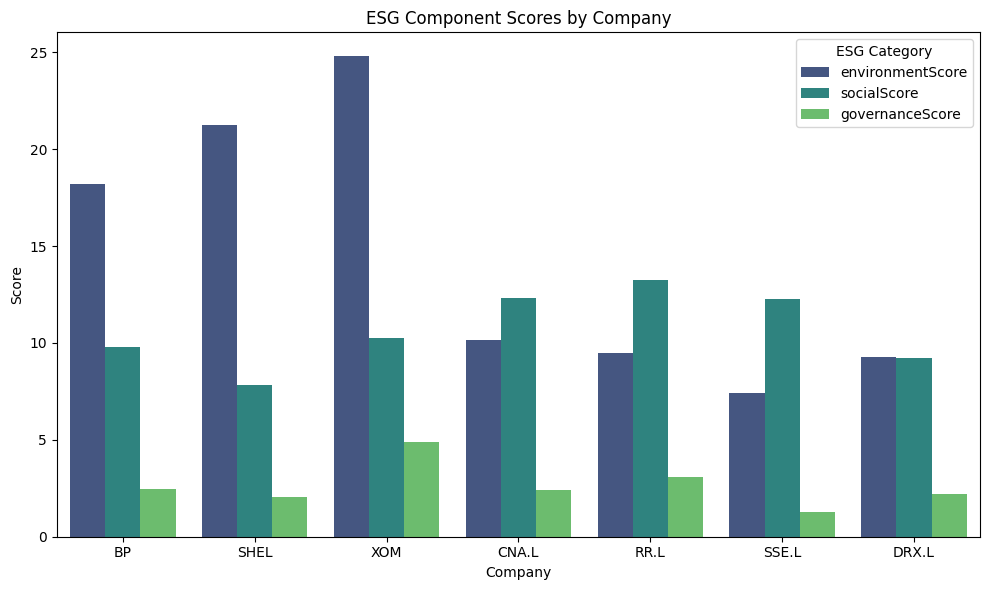

In [527]:
# Select ESG-related columns
esg_cols = ['environmentScore', 'socialScore', 'governanceScore']

# Reshape (melt) for easier plotting
esg_melt = combined_full[esg_cols].reset_index().melt(id_vars='index', var_name='Category', value_name='Score')
esg_melt.rename(columns={'index': 'Company'}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Company', y='Score', hue='Category', data=esg_melt, palette='viridis')
plt.title('ESG Component Scores by Company')
plt.ylabel('Score')
plt.xlabel('Company')
plt.legend(title='ESG Category')
plt.tight_layout()
plt.show()

/Users/otto/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R² Score: -11.78
RMSE: 15.00


/var/folders/m5/pl7f3qbs4wz97g9ld9_84ysw0000gn/T/ipykernel_33757/3863490384.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='crest')


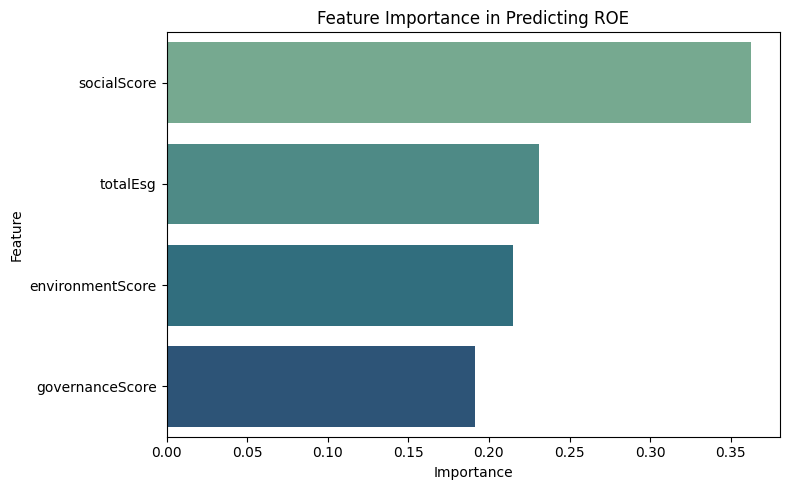

In [533]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Select features (independent variables)
features = ['totalEsg', 'environmentScore', 'socialScore', 'governanceScore']

# Target variable (dependent variable)
target = ['ROE (%)']


# Drop rows with missing values
df_ml = combined_full[features + target].drop(index='RR.L').dropna()

X = df_ml[features]
y = df_ml[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest model
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")



importance = rf.feature_importances_
feat_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feat_importance = feat_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='crest')
plt.title('Feature Importance in Predicting ROE')
plt.tight_layout()
plt.show()

